# This notebook is for the Fair-Shapely experiment

In [16]:
%reload_ext autoreload
%autoreload 2

### 1. Import libraries

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

### 2. Import dataset

In [18]:
from src.data.unified_dataloader import load_dataset

a, processed_compas = load_dataset('compas')

In [19]:
processed_compas.head(3)

,sex,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,c_charge_degree_F,c_charge_degree_M,type_of_assessment_Risk of Recidivism,score_text_High,score_text_Low,score_text_Medium,two_year_recid
0,1,2.875313,-0.141855,-0.187414,-0.218065,-0.711240,0,0,0,0,0,1,1,0,1,0,1,0,0
1,1,-0.068808,-0.141855,-0.187414,-0.218065,-0.711240,1,0,0,0,0,0,1,0,1,0,1,0,1
2,1,-0.909985,-0.141855,-0.187414,1.775750,0.108063,1,0,0,0,0,0,1,0,1,0,1,0,1


### 3. Split label/unlabel data, split train/test data.

In [20]:
'''COMPAS'''
df = processed_compas.copy()
X = df.drop('two_year_recid', axis=1)
y = df['two_year_recid']

# into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=52) 
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (5049, 18)
X_test shape: (2165, 18)


### 4. Train the original model

In [21]:
model = XGBClassifier()  # 可以替换为 RandomForestClassifier() 等其他模型
model.fit(X_train,y_train)

# 预测和评估
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6609699769053118


In [22]:
X_train['sex'].value_counts()

sex
1    4060
0     989
Name: count, dtype: int64

In [23]:
'''把X_train分成majority和minority两个部分'''

male_condition = X_train['sex'] == 1
X_train_majority = X_train[male_condition]
y_train_majority = y_train[male_condition]

female_condition = X_train['sex'] == 0
X_train_minority = X_train[female_condition]
y_train_minority = y_train[female_condition]

### 5. Evaluate the performance of original model

In [24]:
from src.attribution.oracle_metric import perturb_numpy_ver
from src.attribution import FairnessExplainer
sen_att_name = ["sex"]
sen_att = [X_train.columns.get_loc(name) for name in sen_att_name]
priv_val = [1]
unpriv_dict = [list(set(X_train.values[:, sa])) for sa in sen_att]
for sa_list, pv in zip(unpriv_dict, priv_val):
    sa_list.remove(pv)
# print(f'sen_att_name:{sen_att_name}')
# print(f'sen_att:{sen_att}') # index of sensitive attribute
# print(f'priv_val:{priv_val}') # privileged value
# print(f'unpriv_dict:{unpriv_dict}') # unprivileged value(all values in the sensitive attribute, except the privileged value)



''' 
计算DR value的函数
'''
def fairness_value_function(sen_att, priv_val, unpriv_dict, X, model):
    X_disturbed = perturb_numpy_ver(
        X=X,
        sen_att=sen_att,
        priv_val=priv_val,
        unpriv_dict=unpriv_dict,
        ratio=1.0,
    )
    fx = model.predict_proba(X)[:, 1]
    fx_q = model.predict_proba(X_disturbed)[:, 1]
    return np.mean(np.abs(fx - fx_q))
original_test_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_test.values, model)
print(f'original_test_DR: {original_test_DR}')
original_train_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_train.values, model)
print(f'original_train_DR: {original_train_DR}')

original_test_DR: 0.09081892669200897
original_train_DR: 0.0918121188879013


### 5. 把female和male匹配，（或者male和female匹配），然后进行修改，重新训练

2. 初始化FairnessExplainer
3(a). 将X_train_minority_label0与X_train_majority_label0进行匹配
3(b). 将X_train_minority_label1与X_train_majority_label1进行匹配
4(a). 使用fairshap, 从 X_train_majority_label0中找到合适的值替换X_train_minority_label0中的数据
4(b). 使用fairshap, 从 X_train_majority_label1中找到合适的值替换X_train_minority_label1中的数据
5. 计算出varphi和q
shapely value中大于0.1的值的个数有: 36
shapely value中大于0.1的值的个数有: 23


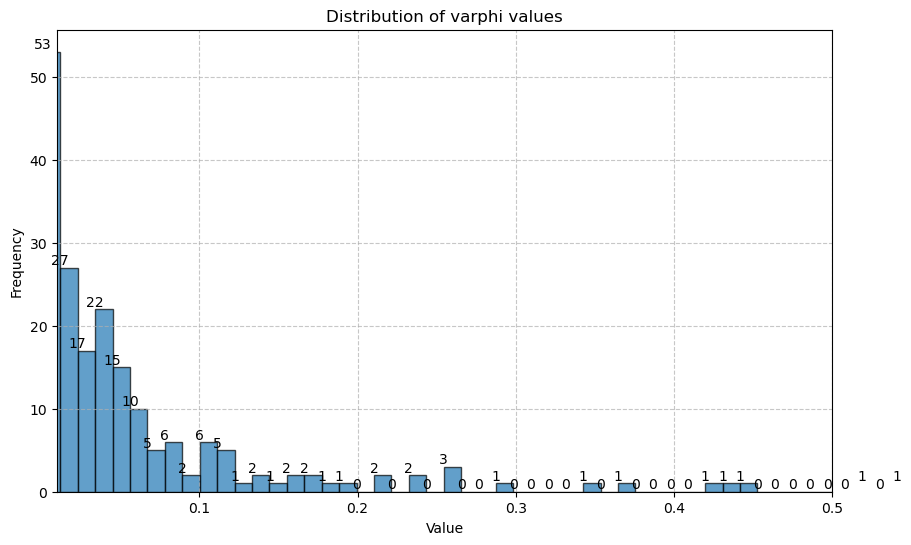

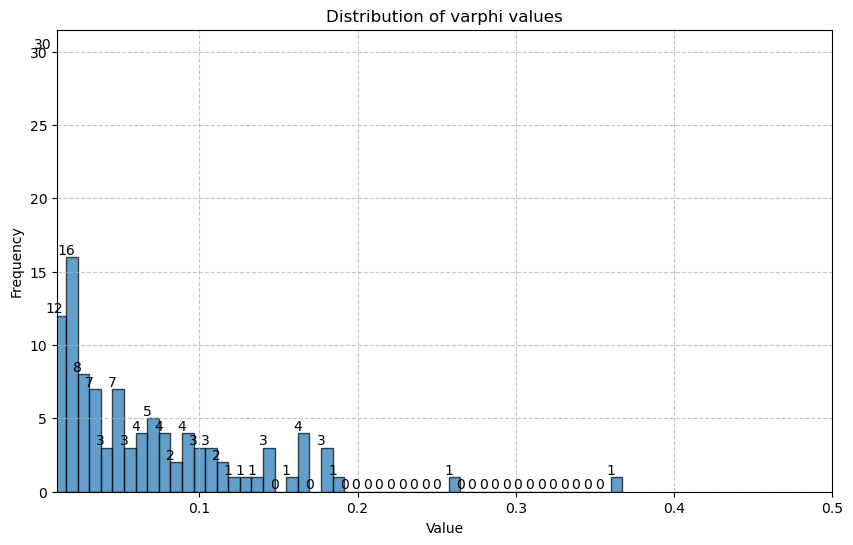

6. 开始整理并且合并新数据,共修改59个数据点, 使用new training set训练新模型
changed_value_info.shape: 58


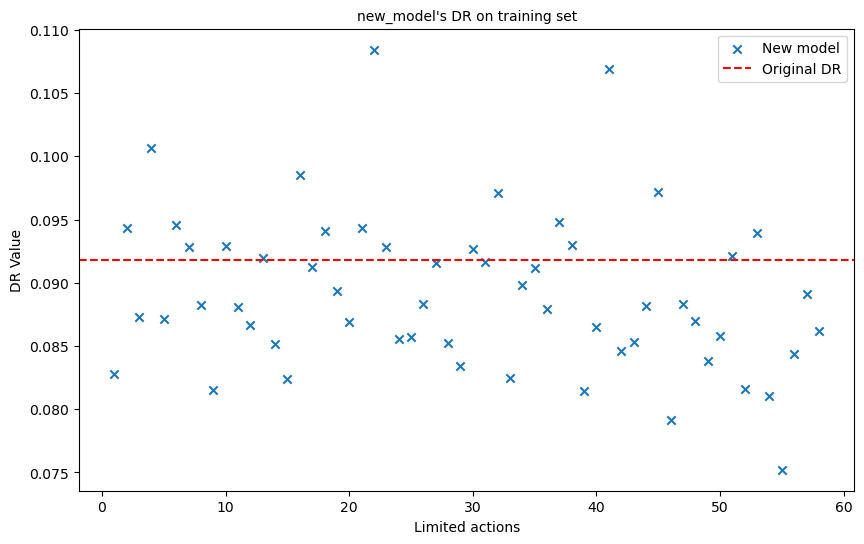

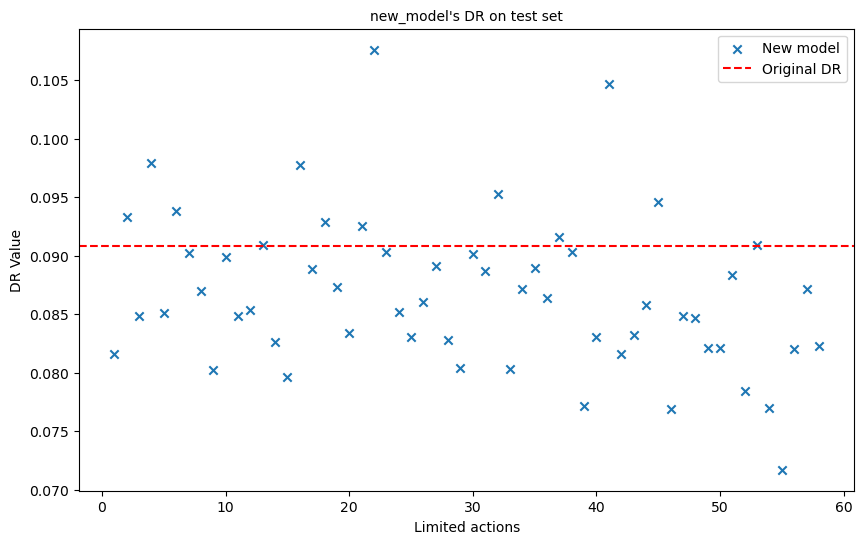

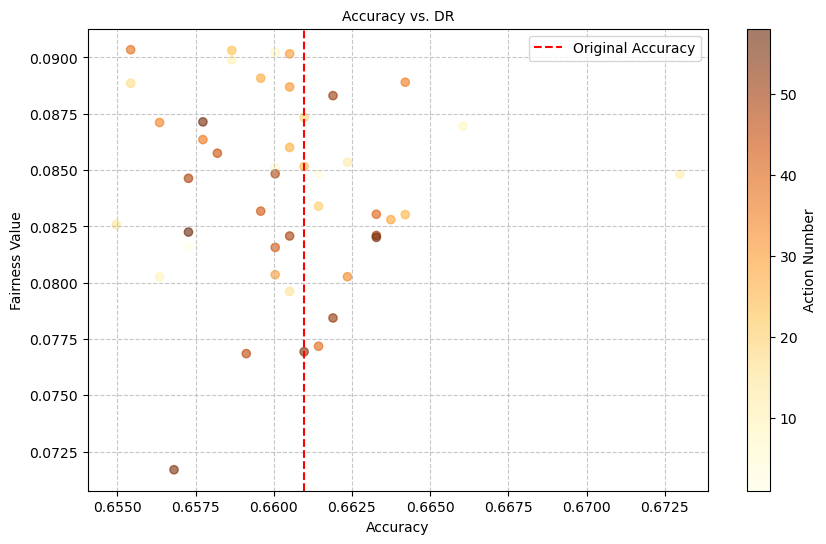

([0.08160933,
  0.09326549,
  0.08482128,
  0.09792851,
  0.08510366,
  0.093776785,
  0.09021439,
  0.08694753,
  0.08026025,
  0.08988856,
  0.08481897,
  0.085348025,
  0.09092686,
  0.08258008,
  0.07960987,
  0.097764395,
  0.08885601,
  0.09285227,
  0.08733446,
  0.08339316,
  0.09254279,
  0.10759249,
  0.09031389,
  0.08515698,
  0.083023146,
  0.086004764,
  0.089078985,
  0.08280125,
  0.08035406,
  0.09016052,
  0.0886914,
  0.09528421,
  0.08026597,
  0.08711264,
  0.08889968,
  0.086354226,
  0.0916111,
  0.09034383,
  0.07717849,
  0.08303891,
  0.104630314,
  0.08156592,
  0.083176725,
  0.085749365,
  0.094572626,
  0.07685121,
  0.084836215,
  0.08463489,
  0.0820733,
  0.08209612,
  0.088304825,
  0.07843306,
  0.09087923,
  0.07693332,
  0.07169628,
  0.08201176,
  0.08714045,
  0.08224852],
 [(0.08160933, 0.6572748267898383, 1),
  (0.08482128, 0.661431870669746, 3),
  (0.08510366, 0.6600461893764434, 5),
  (0.09021439, 0.6600461893764434, 7),
  (0.08694753, 0.66605

In [25]:
from src.experiments_approach2 import ExperimentNew
from src.experiments_approach3 import ExperimentNew2
''' 改变minority group中的部分特征值'''

experiment = ExperimentNew2(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='compas',
                            change_group = 'minority')
experiment.run_experiment()


2. 初始化FairnessExplainer
3(a). 将X_train_majority_label0与X_train_minority_label0进行匹配
3(b). 将X_train_majority_label1与X_train_minority_label1进行匹配
4(a). 使用fairshap, 从 X_train_minority_label0中找到合适的值替换X_train_majority_label0中的数据
4(b). 使用fairshap, 从 X_train_minority_label1中找到合适的值替换X_train_majority_label1中的数据
5. 计算出varphi和q
shapely value中大于0.1的值的个数有: 142
shapely value中大于0.1的值的个数有: 402


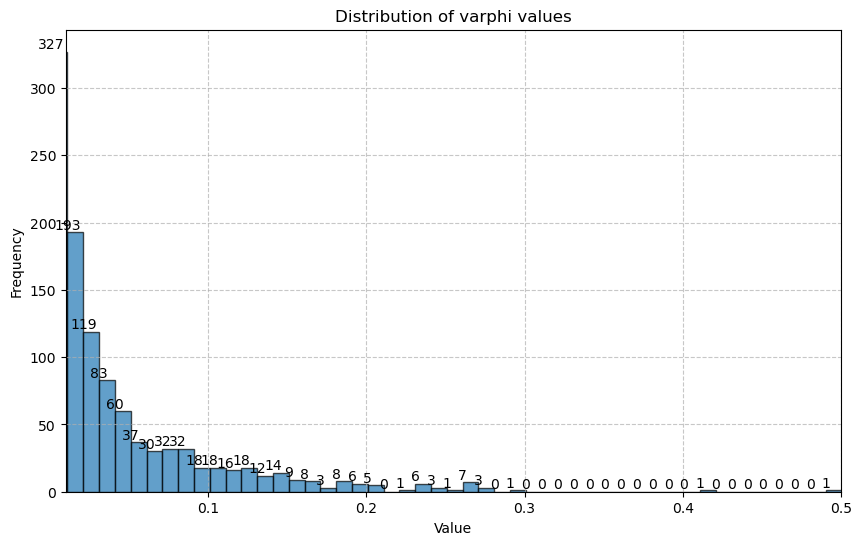

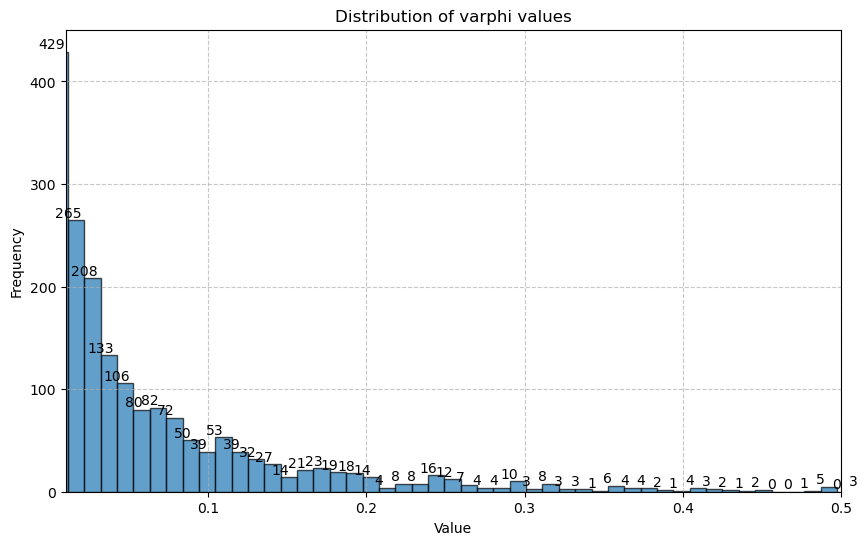

6. 开始整理并且合并新数据,共修改544个数据点, 使用new training set训练新模型
changed_value_info.shape: 543


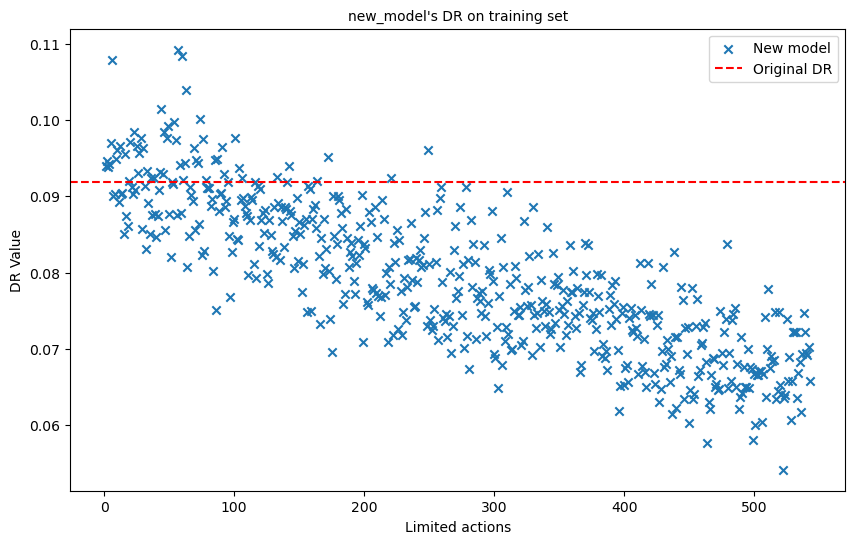

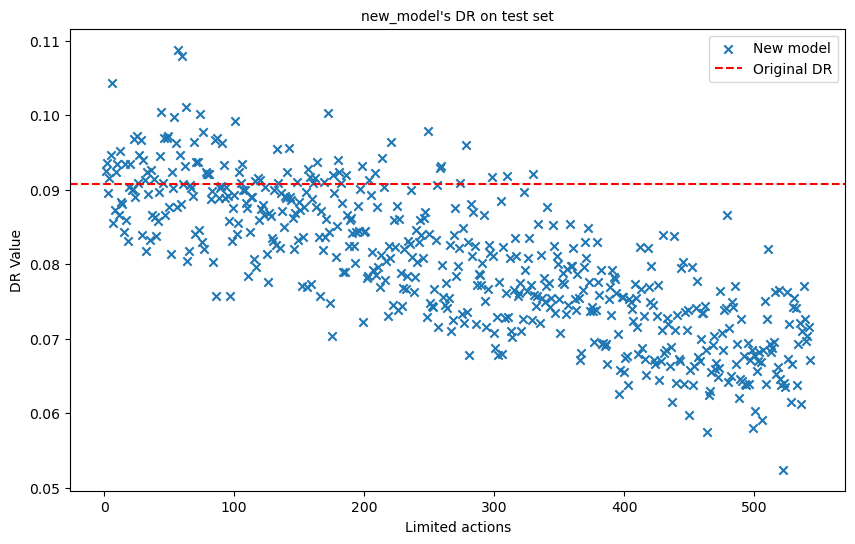

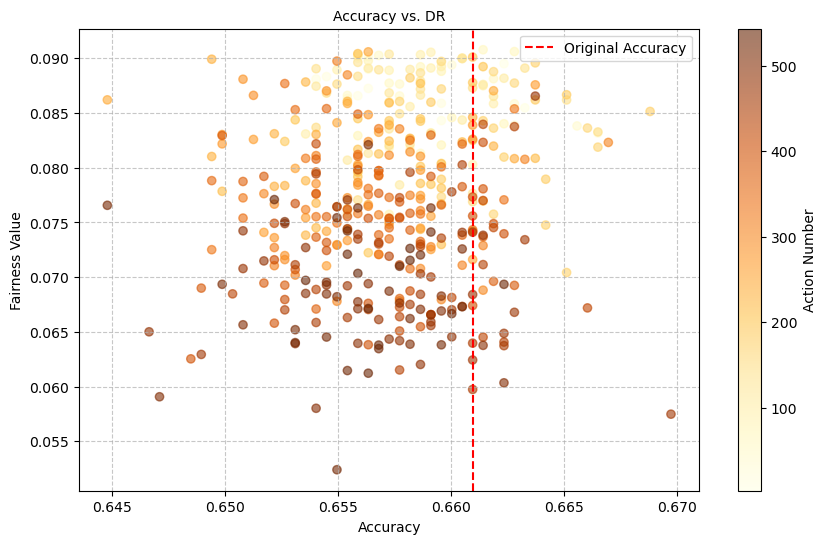

([0.09247132,
  0.09354077,
  0.089508705,
  0.0916111,
  0.0946756,
  0.1043406,
  0.08547942,
  0.08724977,
  0.092354216,
  0.0934795,
  0.086576946,
  0.09514527,
  0.08832923,
  0.08810012,
  0.08431385,
  0.09341078,
  0.08589483,
  0.08316767,
  0.09036155,
  0.09345029,
  0.09002273,
  0.09015305,
  0.096829996,
  0.089008234,
  0.097175874,
  0.09093796,
  0.09461851,
  0.096703306,
  0.083890244,
  0.09401909,
  0.09133179,
  0.08171438,
  0.092369474,
  0.089403294,
  0.0831994,
  0.09262521,
  0.08656267,
  0.09143362,
  0.086331084,
  0.083821625,
  0.08584565,
  0.08966586,
  0.09447888,
  0.10042087,
  0.090881,
  0.096902445,
  0.08661194,
  0.09697177,
  0.097176604,
  0.08765231,
  0.08131965,
  0.09233156,
  0.09027132,
  0.09973655,
  0.09629698,
  0.08773372,
  0.10880436,
  0.0946112,
  0.088137366,
  0.10795414,
  0.0907866,
  0.09320442,
  0.101138696,
  0.08041424,
  0.081834495,
  0.09061935,
  0.09022438,
  0.08922916,
  0.09643208,
  0.08402344,
  0.09379291

In [26]:
''' 改变majority group中的部分特征值'''
experiment2 = ExperimentNew2(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='compas',
                            change_group = 'majority')
experiment2.run_experiment()